In [1]:

import mne
import os 
import numpy as np
import pandas as pd

import re #Para buscar el número final
import glob #Para buscar archivos con tipos específicos
import gui_backend as be


In [2]:
base = r"c:\Users\Josju\Downloads\temp tareas\OpenBCI"
output = base + r"\Epocas_DL"

os.makedirs(output, exist_ok=True)

#Juntar el base con la carpeta de datos
dir_edf = os.path.join(base, r"eeg-motor-movementimagery-dataset-1.0.0\files")
subject_dirs = [os.path.join(dir_edf, d) for d in os.listdir(dir_edf)]
subject_dirs = [d for d in subject_dirs if os.path.isdir(d)]

mov = [
    
    'Fc1.','Fc2.','Fc3.','Fc4.',#Corteza froto-centrañ
    'C3..','C4..','Cz..', #Corteza central
    'Cp1.','Cp2.','Cp3.','Cp4.', #Corteza centro-parietal
    'C1..', 'C2..', 'C5..', 'C6..'  #Canales cercanos a C3 y C4
]



In [3]:
X_list = []
y_list = []
subj_list   = [] 


for sujeto in subject_dirs:
    print(f"📂 Revisando directorio: {sujeto}")

    subject_name = os.path.basename(sujeto)   # e.g. "S001"
    subject_id = int(subject_name[1:])    # 1..109

    edf_files = glob.glob(os.path.join(sujeto, "*.edf")) #Busca todos los archivos adentro que terminen en edf

    for f in edf_files:
        ff = os.path.basename(f)
        #f= la dirección del archivo
        #ff= El nombre del archivo como tal 

        

        m = re.search(r'(\d{2})(?=\.edf$)', ff, flags=re.IGNORECASE)
        
        if not m:
            continue


        n = int(m.group(1))
        # print(sujeto)

        if n in {1, 2}:
            continue
        if not f.lower().endswith(".edf"): #Asegurarnos de ue es un .edf y no un .event (Aunque ya lo verificamos antes )
        
            continue
        

        #print(n)
        raw, labels, mode = be.load_and_pick(f, PICKS = mov)

        clean, _ =be.preprocess(raw, l_freq = 8, h_freq = 30.0, use_notch = True)
        # print("Modo:", mode)
        # print("Labels:", labels)

        epocas = be.epochs(raw_clean=clean, wanted_labels=labels, tmax=3.5, tmin=0.5, baseline = None) #4 segundos es el tamaño de todo evento
        epocas.drop_bad(reject=dict(eeg=150e-6), verbose = "Error")


        if len(epocas) == 0: 
            continue



        X, y = be.ventana(epocas) #Recordar que son muestra, canales, tiempo

        subj_ids = np.full(shape=len(y), fill_value=subject_id, dtype=int)

        X_list.append(X)
        y_list.append(y)
        subj_list.append(subj_ids)

        # print("épocas originales:", len(epocas))
        # print("Ventanas finales", len(X))
        # print("y shape:", y.shape)

X_all, y_all = be.stack_3d(X_list, y_list)

print(X_all.shape)  # (N_total, 8, 160)
print(y_all.shape)  # (N_total,)
subject_all = np.concatenate(subj_list, axis=0)



📂 Revisando directorio: c:\Users\Josju\Downloads\temp tareas\OpenBCI\eeg-motor-movementimagery-dataset-1.0.0\files\S001
📂 Revisando directorio: c:\Users\Josju\Downloads\temp tareas\OpenBCI\eeg-motor-movementimagery-dataset-1.0.0\files\S002
📂 Revisando directorio: c:\Users\Josju\Downloads\temp tareas\OpenBCI\eeg-motor-movementimagery-dataset-1.0.0\files\S003
📂 Revisando directorio: c:\Users\Josju\Downloads\temp tareas\OpenBCI\eeg-motor-movementimagery-dataset-1.0.0\files\S004
📂 Revisando directorio: c:\Users\Josju\Downloads\temp tareas\OpenBCI\eeg-motor-movementimagery-dataset-1.0.0\files\S005
📂 Revisando directorio: c:\Users\Josju\Downloads\temp tareas\OpenBCI\eeg-motor-movementimagery-dataset-1.0.0\files\S006
📂 Revisando directorio: c:\Users\Josju\Downloads\temp tareas\OpenBCI\eeg-motor-movementimagery-dataset-1.0.0\files\S007
📂 Revisando directorio: c:\Users\Josju\Downloads\temp tareas\OpenBCI\eeg-motor-movementimagery-dataset-1.0.0\files\S008
📂 Revisando directorio: c:\Users\Josju\D

In [4]:
CLASS_NAMES = [
    "rest",    # 0
    "right_i", # 1
    "left_i",  # 2
    "hands_i", # 3
    "feet_i",  # 4
    "right_m", # 5
    "left_m",  # 6
    "hands_m", # 7
    "feet_m",  # 8
]

LABEL_TO_IDX = {name: i for i, name in enumerate(CLASS_NAMES)}
IDX_TO_LABEL = {i: name for i, name in enumerate(CLASS_NAMES)}

unique_labels = np.unique(y_all)
print("Etiquetas únicas encontradas en y_all:")
print(unique_labels)


# chequeo rápido:
unknown = [lab for lab in unique_labels if lab not in LABEL_TO_IDX]
if len(unknown) > 0:
    print("⚠️ Etiquetas no contempladas en CLASS_NAMES:", unknown)
else:
    print("✅ Todas las etiquetas están en CLASS_NAMES")

Etiquetas únicas encontradas en y_all:
['feet_i' 'feet_m' 'hands_i' 'hands_m' 'left_i' 'left_m' 'rest' 'right_i'
 'right_m']
✅ Todas las etiquetas están en CLASS_NAMES


In [5]:
# Conversión string -> int usando LABEL_TO_IDX
y_idx_all = np.array([LABEL_TO_IDX[label] for label in y_all], dtype=np.int32)

print("y_idx_all shape:", y_idx_all.shape)
print("Primeros 10:", y_idx_all[:50])

y_idx_all shape: (159215,)
Primeros 10: [0 0 0 0 0 5 5 5 5 5 0 0 0 0 0 6 6 6 6 6 0 0 0 0 0 6 6 6 6 6 0 0 0 0 0 5 5
 5 5 5 0 0 0 0 0 5 5 5 5 5]


GUARDAR ACA ABAJO

In [6]:
dataset_dir = os.path.join(base, "dataset_DL/test2")

os.makedirs(dataset_dir, exist_ok=True)
print("Carpeta creada:", dataset_dir)

save_path = os.path.join(dataset_dir, "EEG_set5+8_dataset.npz")

np.savez_compressed(
    save_path,
    X=X_all.astype(np.float32),
    y=y_idx_all.astype(np.int32),
    class_names=np.array(CLASS_NAMES),
    subject=subject_all.astype(np.int32)
)

print("✔️ Dataset exportado en:")
print("   ", save_path)
print("📦 Contenido:")
print(" - X:", X_all.shape)
print(" - y:", y_idx_all.shape)
print(" - class_names:", CLASS_NAMES)
print(" - subject:", subject_all.shape)

Carpeta creada: c:\Users\Josju\Downloads\temp tareas\OpenBCI\dataset_DL/test2
✔️ Dataset exportado en:
    c:\Users\Josju\Downloads\temp tareas\OpenBCI\dataset_DL/test2\EEG_set5+8_dataset.npz
📦 Contenido:
 - X: (159215, 15, 160)
 - y: (159215,)
 - class_names: ['rest', 'right_i', 'left_i', 'hands_i', 'feet_i', 'right_m', 'left_m', 'hands_m', 'feet_m']
 - subject: (164800,)


SANITY CHECK, NADA DE ACA ABAJO IMPORTA

In [10]:
i = 3   # el par que quieras mirar
ch = 2     # canal que quieras inspeccionar

step_sec = 0.5    
win_samp = X.shape[2]
fs = epocas.info['sfreq']         
step_samp = int(round(step_sec * fs))
overlap = win_samp - step_samp
print("ramaño de vetana y solapamiento en samples:", win_samp, overlap)

print("Últimos 10 samples de w1 en ese canal:")
print(X_all[i, ch, 80:90])
print(y_all[i+1])

print("Primeros 10 samples de w2 en ese canal:")
print(X_all[i+1, ch, 0:10])
print(y_all[i+1])

ramaño de vetana y solapamiento en samples: 160 80
Últimos 10 samples de w1 en ese canal:
[-3.48329648e-06 -4.48733047e-06 -7.19654958e-06 -1.09309929e-05
 -1.31459161e-05 -1.05266079e-05 -2.12901289e-06  8.71316534e-06
  1.62592797e-05  1.65364679e-05]
rest
Primeros 10 samples de w2 en ese canal:
[-3.48329648e-06 -4.48733047e-06 -7.19654958e-06 -1.09309929e-05
 -1.31459161e-05 -1.05266079e-05 -2.12901289e-06  8.71316534e-06
  1.62592797e-05  1.65364679e-05]
rest


Holii

In [2]:
base = r"c:\Users\Josju\Downloads\temp tareas\OpenBCI"

edf_path = os.path.join(base, r"eeg-motor-movementimagery-dataset-1.0.0\files\S090\S090R09.edf")
mov = ['C3..','C4..','Cz..','Fc3.','Fc4.','Cp3.','Cp4.','Pz..']

raw, labels, mode = be.load_and_pick(edf_path, PICKS = mov)
#Plotear señal antes del preprocesamiento
#raw.plot(n_channels=8, duration=10, scalings={'eeg': 100e-6} , title="señal sin procesar")


clean, _ =be.preprocess(raw)
#clean.plot(n_channels=8, duration=30, scalings={'eeg': 100e-6}, title = "Señal procesada" )

print("Modo:", mode)
print("Labels:", labels)

#Sacar épocas

epocas = be.epochs(raw_clean=clean, wanted_labels=labels, scale='small', tmax=4.0, tmin=-0.1)

Modo: HF_M
Labels: ['rest', 'hands_m', 'feet_m']


In [5]:
f = "eeg-motor-movementimagery-dataset-1.0.0/test/S056/S056R01.edf"
raw, labels, mode = be.load_and_pick(f, PICKS = mov)

In [3]:


X, y = be.ventana(epocas) #Recordar que son muestra, canales, tiempo

print("épocas originales:", len(epocas))
print("Ventanas finales", len(X))
print("y shape:", y.shape)

print("Primeras 10 muestras de y", y)





épocas originales: 29
Ventanas finales 203
y shape: (203,)
Primeras 10 muestras de y ['feet_m' 'feet_m' 'feet_m' 'feet_m' 'feet_m' 'feet_m' 'feet_m' 'rest'
 'rest' 'rest' 'rest' 'rest' 'rest' 'rest' 'hands_m' 'hands_m' 'hands_m'
 'hands_m' 'hands_m' 'hands_m' 'hands_m' 'rest' 'rest' 'rest' 'rest'
 'rest' 'rest' 'rest' 'feet_m' 'feet_m' 'feet_m' 'feet_m' 'feet_m'
 'feet_m' 'feet_m' 'rest' 'rest' 'rest' 'rest' 'rest' 'rest' 'rest'
 'hands_m' 'hands_m' 'hands_m' 'hands_m' 'hands_m' 'hands_m' 'hands_m'
 'rest' 'rest' 'rest' 'rest' 'rest' 'rest' 'rest' 'hands_m' 'hands_m'
 'hands_m' 'hands_m' 'hands_m' 'hands_m' 'hands_m' 'rest' 'rest' 'rest'
 'rest' 'rest' 'rest' 'rest' 'feet_m' 'feet_m' 'feet_m' 'feet_m' 'feet_m'
 'feet_m' 'feet_m' 'rest' 'rest' 'rest' 'rest' 'rest' 'rest' 'rest'
 'feet_m' 'feet_m' 'feet_m' 'feet_m' 'feet_m' 'feet_m' 'feet_m' 'rest'
 'rest' 'rest' 'rest' 'rest' 'rest' 'rest' 'hands_m' 'hands_m' 'hands_m'
 'hands_m' 'hands_m' 'hands_m' 'hands_m' 'rest' 'rest' 'rest' 'rest'

In [ ]:

    
size = 1.0
step = 0.5

X = epocas.get_data() #Obtiene todos los datos 
y_ids = epocas.events[:, 2] #Obtiene los eventos 
sfreq = epocas.info['sfreq']

n_epochs, n_channels, n_times = X.shape

#Sacar las clases

event_id = epocas.event_id



id_to_event = {v: k for k, v in event_id.items()}
y_epoch = np.vectorize(id_to_event.get)(y_ids)  # (n_epochs,)

# print(y_ids)
# print(sfreq)
# print(id_to_class)

# --- Tamaños en muestras ---
win_samp  = int(round(size  * sfreq))
step_samp = int(round(step * sfreq))




if win_samp > n_times:
    raise ValueError(f"La ventana ({win_samp} muestras) es más larga que el epoch ({n_times}).")

X_windows = []
y_windows = []

for ep_idx in range(n_epochs):
    ep_data = X[ep_idx]         # (n_channels, n_times)
    label  = y_epoch[ep_idx]

    # recorre inicio en muestras: 0, step, 2*step, ...
    for start in range(0, n_times - win_samp + 1, step_samp):
        end = start + win_samp
        window = ep_data[:, start:end]  # (n_channels, win_samp)

        X_windows.append(window)
        y_windows.append(label)

X_windows = np.stack(X_windows, axis=0)   # (N_ventanas, n_channels, win_samp)
y_windows = np.array(y_windows)

print(y_windows)



In [ ]:
i = 7      # el par que quieras mirar
ch = 2     # canal que quieras inspeccionar

step_sec = 0.5    
win_samp = X.shape[2]
fs = epocas.info['sfreq']         
step_samp = int(round(step_sec * fs))
overlap = win_samp - step_samp
print("ramaño de vetana y solapamiento en samples:", win_samp, overlap)

print("Últimos 10 samples de w1 en ese canal:")
print(X[i+1, ch, 80:19])

print("Primeros 10 samples de w2 en ese canal:")
print(X[i, ch, 0:10])


ramaño de vetana y solapamiento en samples: 160 80
Últimos 10 samples de w1 en ese canal:
[1.61049287e-05 1.36334601e-05 1.07514229e-05 1.02702842e-05
 7.98711931e-06 3.61190857e-06 3.02111864e-06 7.07757770e-06
 8.77751314e-06 3.98376647e-06]
Primeros 10 samples de w2 en ese canal:
['hands_m' 'hands_m' 'hands_m' 'hands_m' 'hands_m' 'hands_m' 'rest' 'rest'
 'rest' 'rest']


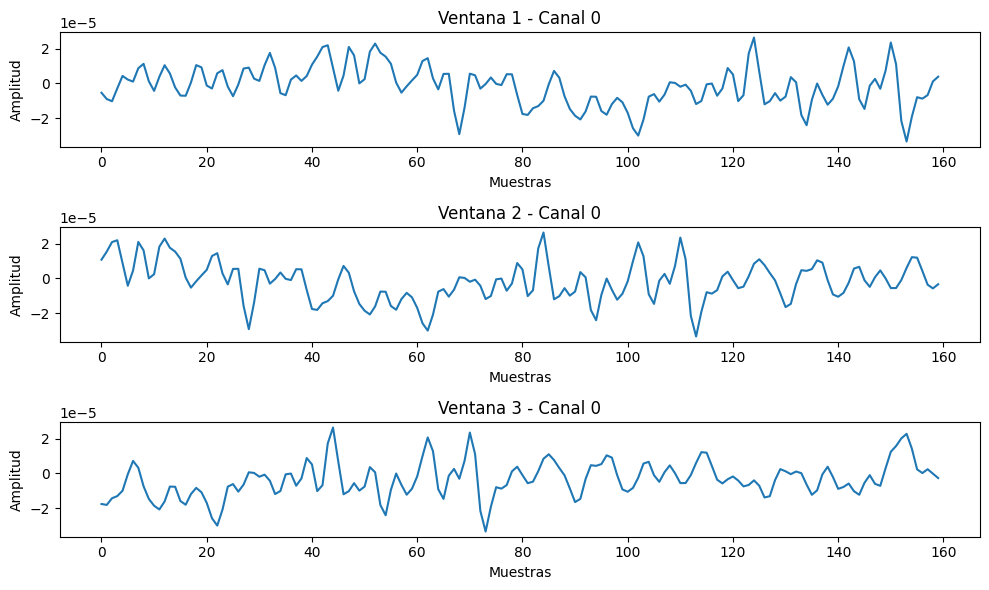

In [ ]:
epochs = epocas

win_sec=1.0
step_sec=0.25

X = epochs.get_data()             # (n_epochs, n_channels, n_times)
y_ids = epochs.events[:, 2]       # IDs de evento (1,2,3,...)
sfreq = epochs.info['sfreq']

n_epochs, n_channels, n_times = X.shape

#Sacar las clases

event_id = epochs.event_id
classes = list(event_id.keys())


#id_to_class = {event_id[name]: i for i, name in enumerate(classes)}


# print(y_ids)
# print(sfreq)
# print(id_to_class)

# --- Tamaños en muestras ---
win_samp  = int(round(win_sec  * sfreq))
step_samp = int(round(step_sec * sfreq))




if win_samp > n_times:
    raise ValueError(f"La ventana ({win_samp} muestras) es más larga que el epoch ({n_times}).")

X_windows = []
y_windows = []

for ep_idx in range(n_epochs):
    ep_data = X[ep_idx]         # (n_channels, n_times)
    label  = y_ids[ep_idx]

    # recorre inicio en muestras: 0, step, 2*step, ...
    for start in range(0, n_times - win_samp + 1, step_samp):
        end = start + win_samp
        window = ep_data[:, start:end]  # (n_channels, win_samp)

        X_windows.append(window)
        y_windows.append(label)

X_windows = np.stack(X_windows, axis=0)   # (N_ventanas, n_channels, win_samp)
y_windows = np.array(y_windows, dtype=int)





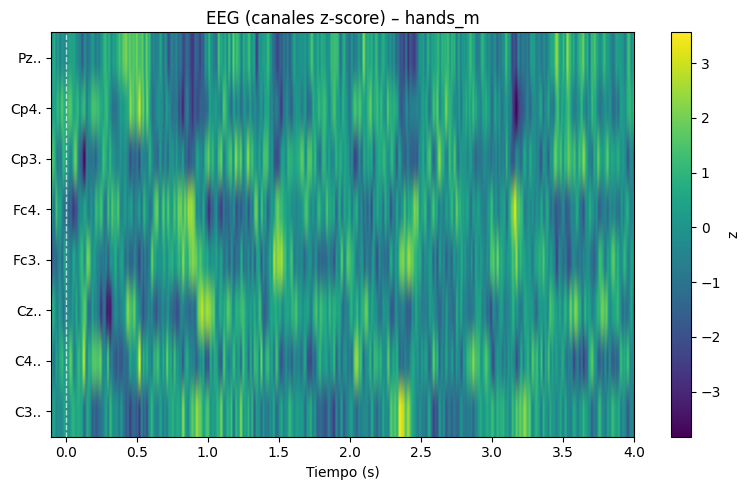

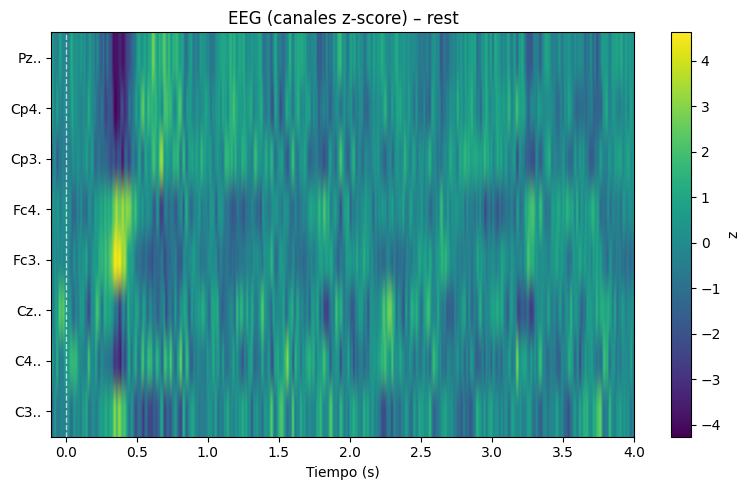

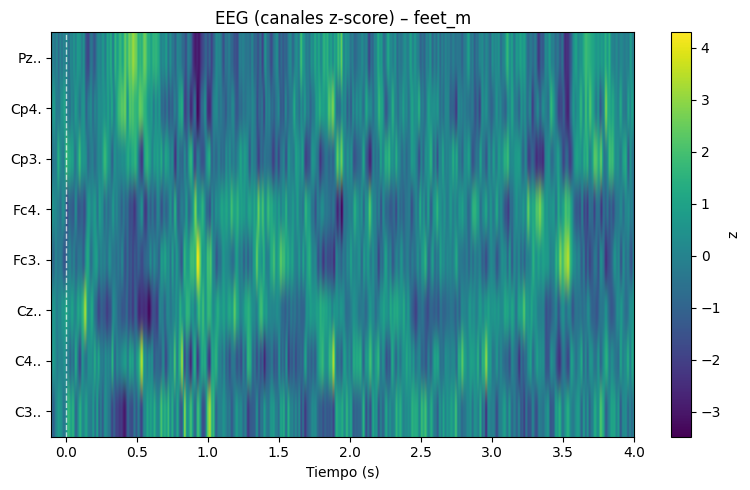

In [37]:
cond = labels[1]
viz = be.EEG(fmax=40)
fig = viz.gfp(epocas, cond=labels[1], ci='sem', mode='channels')
fig = viz.gfp(epocas, cond=labels[0], ci='sem', mode='channels')
fig = viz.gfp(epocas, cond=labels[2], ci='sem', mode='channels')

NameError: name 'epochs' is not defined

In [10]:
raw = mne.io.read_raw_edf(edf_path, preload=True)

ch_types = raw.get_channel_types()          # lista de tipos en el mismo orden que ch_names
df = pd.DataFrame({
    "index": range(len(raw.ch_names)),
    "name": raw.ch_names,
    "type": ch_types
})
df  # en Jupyter se muestra bonito

Extracting EDF parameters from c:\Users\Josju\Downloads\temp tareas\OpenBCI\eeg-motor-movementimagery-dataset-1.0.0\files\S008\S008R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


,index,name,type
0,0,Fc5.,eeg
1,1,Fc3.,eeg
2,2,Fc1.,eeg
3,3,Fcz.,eeg
4,4,Fc2.,eeg
...,...,...,...
59,59,Po8.,eeg
60,60,O1..,eeg
61,61,Oz..,eeg
62,62,O2..,eeg
